In [ ]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

In [ ]:
def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        weather = pd.read_sql_table('weather', con)
        score = pd.read_sql_table('classification', con)
    return milk, weather, score

def merge_data(milk, weather, score):
    milk.reset_index()
    weather.reset_index()
    score.reset_index()
    m = pd.merge(left=milk, right=weather, left_on='date', right_on='date')
    m = pd.merge(left=m, right=score, left_on='animal_id', right_on='animal_id')
    m = m.reset_index()
    return m

def select_features(data):
    milk_features = ['milk_weight', 'average_flow', 'max_flow']
    weather_features =  ['prcp', 'tmax', 'tmin', 'is_hot', 'is_cold', 'is_heatwave', 'is_coldwave']
    score_features =  ['lactation_count', 'stature', 'strength', 'body_depth',
                       'dairy_form', 'rump_angle', 'rump_width', 'rear_legs_side', 'rear_legs_rear',
                       'locomotion', 'foot_angle', 'fore_udder', 'udder_height', 'udder_width',
                       'udder_cleft', 'udder_depth', 'front_teat_placement', 'rear_teat_placement',
                       'teat_length', 'udder_tilt', 'body_condition', 'front_end_capacity_aggregate',
                       'dairy_strength_aggregate', 'rump_aggregate', 'feet_and_legs_aggregate',
                       'udder_score_aggregate', 'final_score', 'breed_age_average', 'category']
    features = milk_features + weather_features + score_features
    
    for col in ['category']:
        data[col] = data[col].astype('category')
        
    for col in ['is_hot', 'is_cold', 'is_heatwave', 'is_coldwave']:
        data[col] = data[col].astype('int')
        
    return pd.get_dummies(data[features].dropna(axis=0, how='any'))

def get_data():
    milk, weather, score = retrieve_data()
    data = merge_data(milk, weather, score)
    return select_features(data)    

In [ ]:
data = get_data()
data.sample(3)

In [4]:
y = data['milk_weight']
X = data.drop(labels=['milk_weight'], axis=1)

In [5]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [6]:
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='median', axis=0)), 
         ('lasso', Lasso())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'lasso__alpha':np.arange(0.05, 1.0, 0.05)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
m_cv = GridSearchCV(pipeline, cv=3, param_grid=parameters)

# Fit to the training set
m_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = m_cv.score(X_test, y_test)
print("Tuned Lasso Alpha: {}".format(m_cv.best_params_))
print("Tuned Lasso R squared: {}".format(r2))

y_pred = m_cv.predict(X_test)

Tuned Lasso Alpha: {'lasso__alpha': 0.050000000000000003}
Tuned Lasso R squared: 0.14098608920208078


### Results

With an R$^2$ of it is clear that only about 14% of the variation in daily produced milk weight was predicted by the data we have captured to this point.  However, a plot of the residuals suggests that a bias may exist in the current model as the plot of residuals suggests that the error does not appear to be independently and identically distributed.

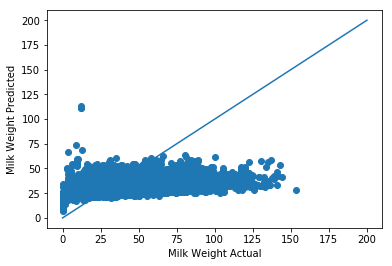

In [7]:
plt.scatter(y_test, y_pred)
plt.plot([0,200],[0,200])
plt.xlabel('Milk Weight Actual')
plt.ylabel('Milk Weight Predicted')
plt.show()

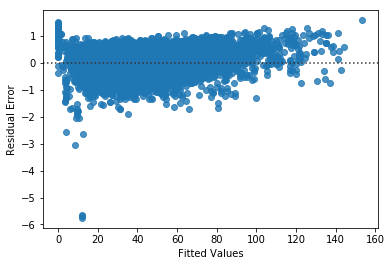

In [36]:
residuals = (np.subtract(y_test, y_pred)) 
normed_residuals = residuals / y_test.std()

sns.residplot(y=normed_residuals, x=y_test)
plt.ylabel('Residual Error')
plt.xlabel('Fitted Values')
plt.show()